<center>

# Trabajo Práctico Final
## Neurociencia computacional - 18.82
### Primer Cuatrimestre 2024

<br/><br/>
<br/><br/>

## _Desarrollo de una biblioteca_ open source _para simular_
##            _y ajustar modelos mecanicistas de neuronas_

<br/><br/>
<br/><br/>


<table>
  <tr>
    <th>Docentes</th>
    <th>Alumnos</th>
  </tr>
  <tr>
    <td>
      Ing. Dante Kienigiel<br>
      Lic. Facundo Emina
    </td>
    <td>
      Juan Bautista Gonzalez Martín - 63549<br>
      Gonzalo Andrés Grau - 62259
    </td>
  </tr>
</table>

<br/><br/>
<br/><br/>
Fecha de entrega: martes 16/06/2024
<br/><br/>

</center>

In [3]:
# Configuración del notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import json
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from concurrent.futures import ThreadPoolExecutor
from typing import Dict, Tuple, Callable, Iterable, Self
# Paquete de modelos de neuronas
from neuron_models.utils import *
from neuron_models.adex import Adex_model, test_adex
from neuron_models.lif import LIF_model, test_lif
from neuron_models.hodgkin_huxley import HodgkinHuxley
from neuron_models.genetic_algo import GeneticAlgorithm
from neuron_models.utils import *
import ipywidgets as widgets
# configuraciones iniciales del notebook
%load_ext autoreload
%autoreload 2

## Resumen

En el presente trabajo se desarrolló una biblioteca en Python que implementa modelos mecanicistas de neuronas mediante clases que permiten tanto simular como ajustar a mediciones reales. Esto último se logró minimizando el error cuadrático en la diferencia de tasas de disparo mediante un algoritmo genético. Se desarrollaron 3 modelos para representar la dinámica neuronal: el de Hodgkin y Huxley (HyH), el _Leaky Integrate and Fire_ (LIF) y el _Adaptive Exponential Integrate and Fire_ (AdEx). Una vez desarrollados, se estudió su respuesta a diversos estímulos de corriente con distintas condiciones iniciales. Por último, se pusieron a prueba los modelos LIF y AdEx ajustando sus parámetros para replicar los resultados de una competencia organizada por _“Collaborative Research in Computational Neuroscience”_  (CRCNS) basada en la simulación de dinámicas neuronales.


## Introducción

Los modelos mecanicistas de potencial de membrana de neurona única permiten estudiar la respuesta eléctrica de una célula ante un estímulo de corriente. Generalmente, están descriptos mediante ecuaciones diferenciales, y cuentan con múltiples parámetros que determinan la dinámica del sistema representado. Una herramienta flexible de código abierto para simular y ajustar los modelos a datos reales sería de gran utilidad para la investigación y pedagogía de la neurociencia computacional. En el presente trabajo, se describirá el desarrollo de la biblioteca  _neuron\_models_, la cual implementa tres modelos mecanicistas distintos y tiene la posibilidad de ampliarse para implementar otros modelos similares.

## Materiales y métodos

Para el desarrollo de este módulo se utilizaron como base las siguiente librerías:
- numpy
- matplotlib
- scipy

A su vez, se hizo uso de otros paquetes como pandas para la visualización de data tabular y concurrent para multithreading. 

Con respecto al dataset utilizado para demostrar el ajuste de los modelos, se utilizaron los datos de la competencia de neurociencia computacional CRCNS 2009 [3]. A partir de datos reales de corriente inyectada y tensión medida de una neurona, el desafío consiste en ajustar un modelo para luego predecir la respuesta de la neurona frente a la corriente. El dataset consta de dos archivos “current.txt” y “voltage_allrep.txt”. El primero contenía la corriente inyectada en la neurona, la misma corriente tenía dos fases: una inicial de entrenamiento que constaba de 4 pulsos cuadrados y otra de testeo en forma de ruido.

<center>

<img src="foto_challenge.png" alt="drawing" width="200"/>

_Fig. 1: ilustración del experimento de la competencia CRCNS 2009_

</center>

A continuación, procedemos a visualizar las mediciones

En primer lugar, se visualizará la corriente aplicada a las neuronas como estímulo. Los primeros 17.5 segundos consisten de un estímulo pulsátil prefijado, los cuales se utilizan para calibrar y ajustar el modelo. Luego, se inyecta ruido blanco para los estímulos de testeo.

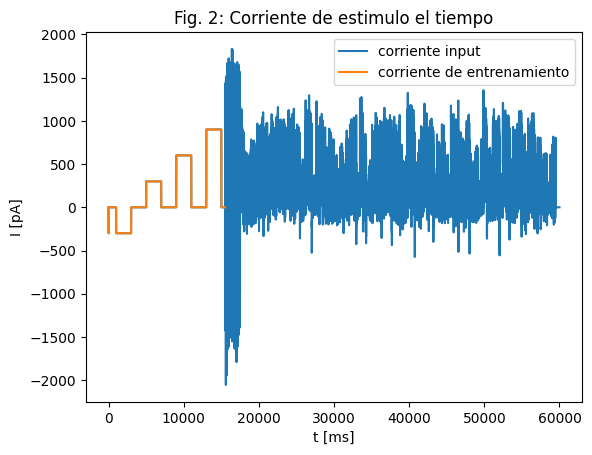

In [4]:
# Leemos la corriente
fig_count = 2
corrientes = r"dataset/current.txt"
data = np.loadtxt(corrientes, delimiter=',')
I_data= np.loadtxt(corrientes, delimiter=',')*pA

t_max = 60*1e3*ms
train_end_t = 155000
fs = len(I_data-1)/t_max
t_total = np.arange(0, t_max, 1/fs)
t_train = t_total[:train_end_t]
t_test = t_total[train_end_t:]
I_train = I_data[:train_end_t]
I_test = I_data[train_end_t:]

plt.plot(t_total/ms, I_data/pA, label='corriente input')
plt.plot(t_train/ms, I_train/pA, label='corriente de entrenamiento')
plt.xlabel('t [ms]')
plt.ylabel('I [pA]')
plt.title(f'Fig. {fig_count}: Corriente de estimulo el tiempo')
plt.legend()
plt.show()

 Por otro lado, las mediciones de potencial de membrana se encuentran en “voltage_allrep.txt”. Este archivo contiene 12 repeticiones del experimento. Se visualizará a continuación la medición de la primera realización como respuesta a la corriente de entrenamiento.


In [5]:
# Leemos las mediciones de voltaje
path = r"dataset/voltage_allrep.txt"
headers = [f"rep{i+1}" for i in range(12)]
v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)
v_train = v_data["rep1"][:train_end_t]
v_test = v_data["rep1"][train_end_t:]
t_test = np.array(t_test[:len(v_test)])
t_test -= t_test[0]
I_test = I_test[:len(v_test)]

C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_19016\4058418432.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)
C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_19016\4058418432.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  v_data = pd.read_csv(path, delimiter="  ", header=None, names=headers, index_col=False)


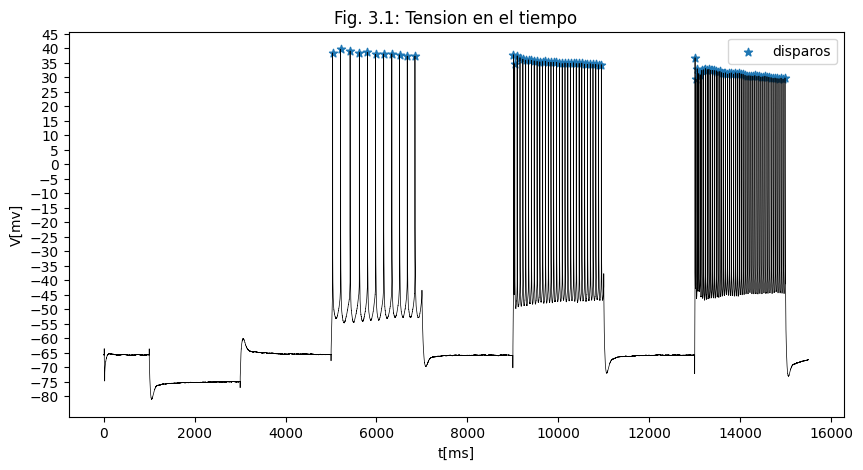

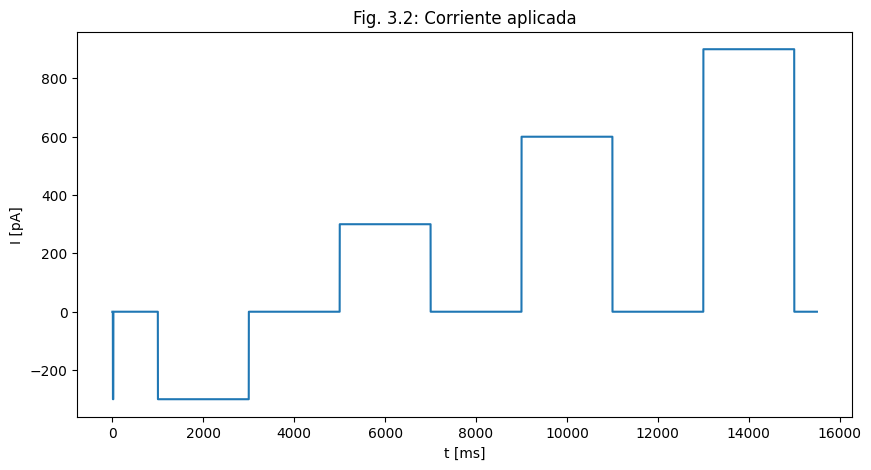

In [6]:
# Graficamos
fig_count += 1

spike_times_train, training_peaks_h = find_peaks(v_train, height=0)
plt.figure(figsize=(10, 5))
plt.plot(t_train/ms, v_train, "k-", linewidth=0.5)
plt.scatter(spike_times_train / (fs * ms), v_train[spike_times_train], marker="*",label="disparos")
plt.xlabel('t[ms]')
plt.ylabel('V[mv]')
plt.title(f'Fig. {fig_count}.1: Tension en el tiempo')
plt.yticks(np.arange(-80, 50, 5))
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t_train/ms, I_train/pA)
plt.xlabel('t [ms]')
plt.ylabel('I [pA]')
plt.title(f'Fig. {fig_count}.2: Corriente aplicada')
plt.show()

## Desarrollo

### Estructura general de la biblioteca

La biblioteca implementada cuenta con los siguientes archivos:

- **\_\_init\_\_.py**: archivo de inicialización del módulo, para el manejo de paquetes
- **utils.py**: paquete con funciones y constantes generales compartidas por todos los modelos
- **genetic_algo.py**: implementación de la clase GeneticAlgorithm que se utiliza para el ajuste de los modelos a mediciones relae
- **base_model.py**: el corazón de la biblioteca, en donde se define la clase madre NeuronModel que generaliza los métodos y atributos básicos de los modelos implementados
- **hodgkin_huxley.py, lif.py, adex.py**: implementaciones de los modelos correspondientes mediante herencia con NeuronModel

### Manejo de unidades

Las unidades utilizadas para definir parámetros se implementaron como constantes, disponibles en utils.py. Por ejemplo:

In [7]:
pV = pA = pS = ps = 1e-12
nV = nA = nS = ns = 1e-9
uV = uA = uS = us = uF = 1e-6
mV = mA = mS = ms = 1e-3
cm = 0.01
Mohm = 1e6

### NeuronModel

La clase NeuronModel cuenta con los métodos para:
- inicializar un objeto "modelo" genérico, 
- actualizar sus parámetros
- ajustar sus parámetros a una medición

En particular, los atributos se inicializan mediante los valores ingresador por el usuario o adoptando valores prestablecidos por defecto. Para ajustar a una medición, se toma como referencia los instanes de disparo de la neurona real, y se minimiza el error cuadrático medio entre las tasas de disparo binneadas del modelo y las de las mediciones. Es decir: se calcula el firing_rate en ventanas de tiempo, y se busca que la cantidad de spikes en cada ventana sea idéntica entre la simulación y la medición. Esto se implementó mediante un algoritmo genético, que se explicará a continuación.

_Observación: a la hora de ajustar los parámetros, primero se los divide por su unidad característica. Esto permite que el algoritmo de ajuste trabaje con valores en idéntica escala, para evitar que se favorezca un parámetro por sobre otro._ 

In [43]:
################################################################
# Lo siguiente NO es el código fuente, es una demo ilustrativa #
# Para ver la versión original, ver el archivo base_model.py   #
################################################################

class NeuronModel_(object):
    """
    Base class for all neuron models
    Adex, LIF, and Hodgkin-Huxley are sublclasses of this class
    this defines how to initialize, get, and set parameters
    """
    def __init__(self, default_values: Dict[str, float], valid_keys: Iterable[str], **kwargs):
        # Parameters can be set either by passing them as kwargs...
        for name, value in kwargs.items():
            if name not in valid_keys:
                raise ValueError(f"{name} is not a valid attribute for this class")
            setattr(self, name, value)
        # ... or set by default
        for def_name, def_val in default_values.items():
            if getattr(self, def_name) is None:
                setattr(self, def_name, def_val)

    ...

    def fit_spikes(self, t: np.ndarray,
                    obj_spikes: np.ndarray,
                    I_input: np.ndarray,
                    n_per_bin: int=10,
                    tweak_keys: List['str'] | None=None,
                    tweak_units: List[int | float] | None=None,
                    N_iter: int=1000,
                    max_rep: int=10,
                    pop_size: int=100,
                    mut_rate: float=0.01,
                    mut_scale: float=1.) -> None:
        """
        Tweaks the object's parameters to fit a voltage curve using genetic algorithms
        :param t: time array
        :param obj_spikes: neuron spike readings
        :param I_input: input current
        :param n_per_bin: bins for the firing rate calculation
        :param tweak_keys: parameters to tweak
        :param tweak_units: units for said parameters
        :param pop_size: population size for GA
        :param N_iter: maximum number of algorithm iterations
        :param max_rep: maximum amount of succesive unevolutive generations
        :param mut_rate: float in [0, 1) for mutation rate in GA
        :param mut_scale: standard deviation of normal mutation
        :return: None, but the internal parameters are tweaked to the best fitting
        """

        obj_rates = firing_rate(t, obj_spikes, n_per_bin)
        init_pars = self.get_init_pars_2_fit(tweak_keys, tweak_units)

        def fitness_function(pars: np.ndarray, lif_obj: Self, keys, units):
            lif_obj.update_params(keys, pars, units)
            _, sim_spikes = lif_obj.simulate_trajectory(t, I_input)
            sim_rates = firing_rate(t, sim_spikes, n_per_bin)
            rate_error = np.sum((obj_rates - sim_rates)**2)
            # timing_error = sum([abs(t1 - t2) for t1, t2 in zip(sim_spikes, obj_spikes)])
            return 1 / (1 + rate_error)

        algo_obj = GeneticAlgorithm(pop_size, N_iter, max_rep, mut_rate, mut_scale, fitness_function, init_pars)
        best_solution = algo_obj.genetic_algorithm(self, tweak_keys, tweak_units)

        self.update_params(tweak_keys, best_solution, tweak_units)

### Algoritmo genético

La clase  _GeneticAlgorithm_ del archivo genetic_algo.py implementa el siguiente algoritmo:

1) Primero, se genera una poblacion de posibles parametros solucion al modelo
2) Luego se seleccionan los que tienen mejor "Fitteo", es decir se evalua que tan buena solucion es
3) Despues se genera un crossover entre soluciones 
4) Este crossover tiene la posibilidad de sufrir mutaciones que son variaciones aleatorias, la posibilidad de sufrir una mutacion se define con el mut_rate
5) Se genero una nueva poblacion y se vuelve a empezar con el algoritmo hasta que se cumple una cierta cantidad de repeticiones

In [44]:
################################################################
# Lo siguiente NO es el código fuente, es una demo ilustrativa #
# Para ver la versión original, ver el archivo genetic_algo.py #
################################################################

class GeneticAlgorithm_(object):
    def __init__(self, pop_size: int,
                 N_iter: int,
                 max_rep: int,
                 mut_rate: float,
                 mut_scale: float,
                 fitness_function: Callable,
                 init_pars: np.ndarray):
        """
        Definimos el objeto de algoritmo genético
        :param pop_size: cantidad de individuos en la población
        :param N_iter: cantidad máxima de generaciones
        :param max_rep: cantidad máxima permitida de genraciones sucesivas sin mejora
        :param mut_rate: pernece a [0, 1], indica la probabilidad de mutar de un individuo
        :param fitness_function: función que define qué tan buena es una población
        :param init_pars: valores iniciales para los parámetros del algoritmo
        """
        ...

    def initialize_population(self, init_pars: np.ndarray) -> np.ndarray:
        ...

    def select_parents(self, fitnesses, num_parents):
        ...

    def crossover(self, parents, offspring_size: Tuple[int, int]):
        ...

    def mutate(self, offspring):
        ...

    def evaluate_fitness(self, population, *args, **kwargs):
        ...

    def genetic_algorithm(self, *args, **kwargs) -> np.ndarray:
        """
        Generar poblaciones iterativas, seleccionar a los mas aptos, reproducirlos, mutar algunos, repetir
        :param args: argumentos por posicion para la funcion de fitness
        :param kwargs: argumentos por keyword para la funcion de fitness
        :return: la mejor combinacion de parametros
        """
        ...

### Calculo de la tasa de disparo

Como función de costo para minimizar en el ajuste, utilizamos el error cuadrático medio (ECM) de las tasas de disparo en ventanas de tiempo entre la señal original y la simulada. Para ello, implemetnamos una función que cuenta las ocurrencias de spikes en _bins_ de un array de muestras temporales, de la siguiente manera:

In [45]:
def firing_rate(t: np.linspace, spike_times: np.ndarray | List[int], n_per_bin: int=10) -> np.ndarray:
    """
    Generates a numpy array with the firing rate (in spikes per time unit) of a spike train
    :param t: time samples
    :param spike_times: indeces such that a neuron fires at t[index]
    :param n_per_bin: amount of time samples per bin, defaults to 10
    :return: an array of shape(len(t)//n_bins)
    """
    t = np.asarray(t)
    t_len = len(t)
    bin_edges = np.arange(0, t_len + n_per_bin, n_per_bin)
    spike_bins = np.digitize(spike_times, bin_edges, right=True) - 1
    rates = np.bincount(spike_bins, minlength=t_len//n_per_bin)[:t_len//n_per_bin]

    return rates

_Observación: técnicamente, la verdadera "tasa de disparos" se obtendría dividiendo el array que devuelve esta función por el intervalo de tiempo en cada bin. Si bien esto podría implementarse fácilmente con una línea de código adicional, optamos por devolver la **cantidad** de disparos por bin, para trabajar así con números enteros y evitar errores de punto flotante. Esto no afecta a los resultados obtenidos, ya que es simplemente una cuestión de escala_

### Implementación general de los modelos de neurona

Tanto *HodgkinHuxley* como *Adex_model* y *LIF_model* son subclases de la ya mencionada *NeuronModel*. Para cada nuevo modelo, se deben especificar:

1) Atributos (parámetros) válidos
2) Parámetros por defecto
3) Método para calcular la derivada de las variables representadas (voltaje, apertura/cierre de canales, etc. según corresponda)
4) Método para simular la trayectoria temporal de las variables como respuesta a un estímulo de corriente


## Modelo de Hodgkin y Huxley

El modelo HyH intenta caracterizar la apertura y cierre de los canales de Sodio y Potasio de la membrana de la neurona que harán que la concentración de iones suba o baje y que en definitiva el potencial de membrana cambie. HyH trata de relacionar las neuronas con componentes electrónicos cuyo comportamiento se conoce matemáticamente, para de esta manera poder formar un modelo matemático. Se modela a cada compuerta como una conductancia g y a la membrana como un capacitor. 


Donde se plantea el modelo como la siguiente combinacion de EDOS:


donde:

\begin{aligned}
C \dot{v}(t) &=i(t)-g_{\mathrm{Na}} m^3 h\left(v-v_{\mathrm{Na}}\right)-g_{\mathrm{K}} n^4\left(v-v_{\mathrm{K}}\right)-g_{\mathrm{L}}\left(v-v_{\mathrm{L}}\right) \quad t>0, \\
\dot{n} &=\alpha_n(v)(1-n)-\beta_n(v) n, \\
\dot{m} &=\alpha_m(v)(1-m)-\beta_m(v) m, \\
\dot{h} &=\alpha_h(v)(1-h)-\beta_h(v) h . \\
\\
\end{aligned}


donde $\alpha_x, \beta_x$ se expresan en $\mathrm{ms}^{-1}, g_x$ en $\mathrm{mS} / \mathrm{cm}^3, v_x$ en $\mathrm{mV}$ y $C$ en $\mu \mathrm{F} / \mathrm{cm}^3$, y donde:


\begin{aligned}
&\alpha_n(v)=0.010 \frac{v+55}{1-e^{-\frac{v+55}{10}}}, \quad \beta_n(v)=0.125 e^{-\frac{v+65}{80}}, \\
&\alpha_m(v)=0.100 \frac{v+40}{1-e^{-\frac{v+40}{10}}}, \quad \beta_m(v)=4.000 e^{-\frac{v+65}{18}}, \\
&\alpha_h(v)=0.070 e^{-\frac{v+65}{20}}, \quad \quad \beta_h(v)=\frac{1}{1+e^{-\frac{v+35}{10}}}, \\
&g_{\mathrm{Na}}=120, \quad g_{\mathrm{K}}=+36, \quad g_{\mathrm{L}}=0.3, \\
&v_{\mathrm{Na}}=50, \quad v_{\mathrm{K}}=-77, \quad v_{\mathrm{L}}=-54.4, \\
&C=1 . \\
&
\end{aligned}


Para las simulaciones que realizaremos, asumiremos que la corriente aplicada se fija a un valor constante, de modo que $i(t)=i_0 , \forall t > 0$

Para acceder al código fuente completo que define la clase del modelo, referirse a hodgkin_huxley.py. A modo ilustrativo, se mostrarán a continuación algunos extractos del mismo.

En el siguiente codigo se definen las funciones alfa y beta:

In [46]:
#####################################################################
# El siguiente código es un extracto del archivo hodgkin_huxley.py  #
#      para ver la fuente completa, referirse a dicho archivo       #
#####################################################################

@staticmethod
def alpha_n(v: float):
    return 0.010 * (v + 55)/(1 - np.exp(-(v + 55)/(10)))

@staticmethod
def alpha_m(v: float) -> float:
    return 0.100 * (v + 40) / (1 - np.exp(-(v + 40) / (10)))

@staticmethod
def alpha_h(v: float) -> float:
    return 0.070 * np.exp(-(v + 65) / (20))

@staticmethod
def beta_n(v: float) -> float:
    return 0.125 * np.exp(-(v + 65) / 80)

@staticmethod
def beta_m(v: float) -> float:
    return 4.0 * np.exp(-(v + 65) / 18)

@staticmethod
def beta_h(v: float) -> float:
    return 1 / (1 + np.exp(-(v + 35) / 10))

Definimos a la derivada a resolver:




In [47]:
def derivative(self, t: float, X: np.ndarray, i: Callable) -> np.ndarray:
        """
        Instantenous derivative for the Hodgkin and Huxley model
        :param: X: np.array([v, n, m, h])
        :param: i: current as a function of time
        :return: np.array([dv, dn, dm, dh])/dt
        """
        # Define constants
        s = self
        v = X[0]
        n = X[1]
        m = X[2]
        h = X[3]
        # Compute derivative
        dv = (i(t) - s.g_Na * m ** 3 * h * (v - s.V_Na) - s.g_K * n ** 4 * (v - s.V_K) - s.g_L * (v - s.V_L)) / s.C
        dn = s.alpha_n(v) * (1 - n) - s.beta_n(v) * n
        dm = s.alpha_m(v) * (1 - m) - s.beta_m(v) * m
        dh = s.alpha_h(v) * (1 - h) - s.beta_h(v) * h
        return np.array([dv, dn, dm, dh])

Finalmente simulamos usando nuestro metodo de resolucion de EDOS preferido, en solve_ivp de scipy

In [48]:
def simulate_trajectory(self, t: np.ndarray,
                            i: Callable,
                            plot: bool = False,
                            t_units: float = 1,
                            v_units: float = 1) -> Tuple[np.ndarray, List[int]]:
        """
        :param np.ndarray t: time array of len N, defined as the range a:h:b
        :param np.ndarray i: current as a function of time
        :param plot: indicates whether to plot
        :param t_units: for plotting purposes
        :param v_units: for plotting purposes

        Uses the Runge-Kutta 4 method to solve the model

        :return  X such that. X[0, :] = V, X[1, :] = n, X[2, :] = m, X[3, :] = h, and spike times
        """
        s = self
        X_0 = np.array([s.V_init, s.n_init, s.m_init, s.h_init])
        derivative = lambda t_val, X_arr, i_func : self.derivative(t_val, X_arr, i_func)
        res = solve_ivp(derivative, t_span=(t[0], t[-1]), args=(i,), t_eval=t, method='LSODA', y0=X_0)
        X = res.y
        V = X[0, :]
        spike_times = list(find_peaks(V, height=0)[0])

        if plot:
            fig, ax = plt.subplots()
            ax.plot(t/t_units, V/v_units, 'k-', linewidth=0.5)
            ax.set_xlabel('t [ms]')
            ax.set_ylabel('V [mV]')
            plt.show()

        return X, spike_times

 A continuación, probamos el metodo

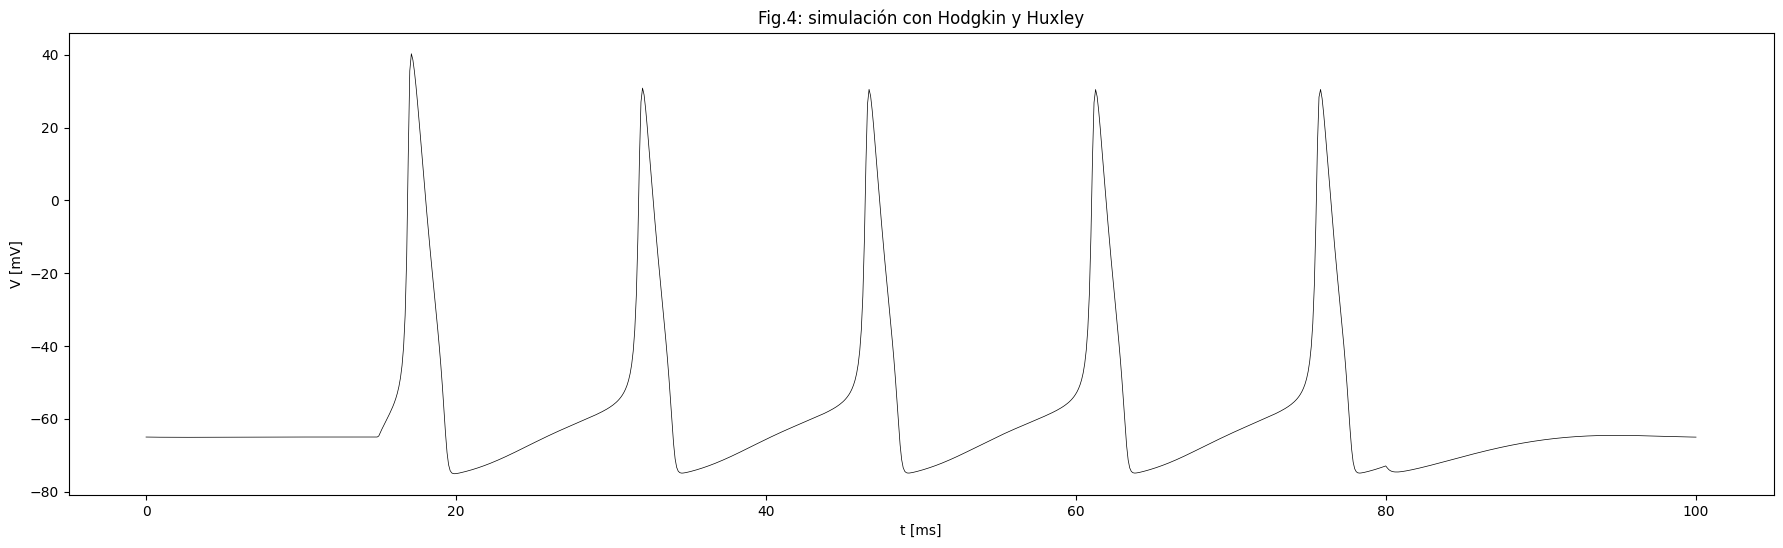

In [8]:
hyh_neuron = HodgkinHuxley()
t_hyh = np.linspace(0, 100, 1000)
i_0 = 10  # [uA/cm^3]
i = lambda t_i: i_0 * (t_i > 15) * (t_i < 80)

fig_count += 1
title = f"Fig.{fig_count}: simulación con Hodgkin y Huxley"

X_hyh, spike_times_hyh = hyh_neuron.simulate_trajectory(t_hyh, i, plot=True, title=title);

Nótese que este modelo devuelve, además del valor de V en función de t, las activaciones de las compuertas n, m, y h. Todo esto está empaquetado en la variable "X?hyh" que retorna la simulación

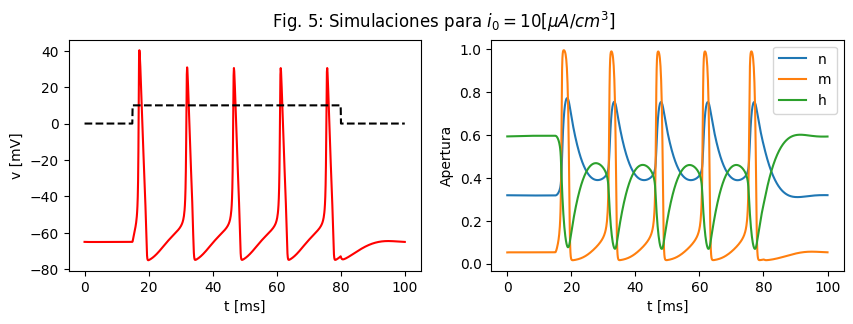

In [9]:
fig_count += 1

# extraemos las variables
v_vals = X_hyh[0, :]
n_vals = X_hyh[1, :]
m_vals = X_hyh[2, :]
h_vals = X_hyh[3, :]
I_hyh = np.vectorize(i)(t_hyh)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(t_hyh, v_vals, 'red')
axs[0].plot(t_hyh, I_hyh, 'k--')
axs[0].set_xlabel('t [ms]')
axs[0].set_ylabel('v [mV]')
axs[1].plot(t_hyh, n_vals, label='n')
axs[1].plot(t_hyh, m_vals, label='m')
axs[1].plot(t_hyh, h_vals, label='h')
axs[1].set_xlabel('t [ms]')
axs[1].set_ylabel('Apertura')
plt.legend(loc='upper right')
fig.suptitle(rf'Fig. {fig_count}: Simulaciones para $i_0=10 [\mu A/cm^3]$')
plt.show()


# Leaky integrate and fire

El modelo LIF plantea la siguiente ecuación para el potencial de membrana:

\begin{equation}
\tau_m\frac{dV}{dt} = -(V-E_L) + \frac{I}{g_L}\,
\end{equation}

Donde $V$ es el potencial de membrana, $g_L$ es la conductancia de fuga, $E_L$ es el potencial de reposo, $I$ es el valor de entrada de la corriente externa y  $\tau_m$ es la constante de tiempo de la membrana. Además, se agrega la condición de que cuando la neurona excede un potencial umbral $V_{th}$, indicamos que hubo un disparo y el potencial automáticamente vuelve a su valor de reposo. Luego, durante un período refractario $t_{ref}$, el potencial queda fijo en dicho valor.

### Al igual que con HyH modelamos LIF dentro de una clase, por lo que vamos a mostrar el funcionamiento del mismo con fragmentos de codigo que no

Calculamos la derivada:

In [51]:
def derivative(self, I_val: float, u: float) -> np.ndarray:
        """
        Computes the instantaneous derivative
        :param I_val: current current (hehe)
        :param u: current voltage
        :return: du/dt
        """
        s = self  # alias for neat code
        du = -(u - s.E_L) + I_val / s.g_L
        return du / s.tau_m

Simulamos teniendo en cuenta tanto el reseteo como el periodo refractario:

In [52]:
def simulate_trajectory(self, t: np.ndarray,
                            I_input: np.ndarray,
                            plot: bool = False,
                            t_units: float = ms,
                            v_units: float = mV) -> Tuple[np.ndarray, np.ndarray]:
        """
        Solves IVP to find the trajectory v(t)
        :param t: time samples
        :param I_input: input current, same shape as t
        :param plot: indicates whether to plot
        :param t_units: for plotting purposes
        :param v_units: for plotting purposes
        :return: V, same shape as t, and a list of spike times
        """
        s = self
        V = np.zeros_like(t)
        dt = t[1] - t[0]
        V[0] = self.V_init
        ref_counter = 0
        spike_times = []
        # Simulamos
        for i in range(1, len(t)):
            V_next = V[i - 1] + s.derivative(I_input[i - 1], V[i - 1]) * dt

            # Caso 1: estamos en periodo refractario
            if ref_counter > 0 or V[i - 1] == s.V_fire:
                V[i] = s.V_reset
                ref_counter -= dt

            # Caso 2: disparo
            elif V_next >= s.V_th:
                V[i] = s.V_fire
                ref_counter = s.tref
                spike_times.append(i)

            # Caso 3: nada en particular, integramos
            else:
                V[i] = V_next

        if plot:
            plot_voltage(t, V, t_units, v_units)

        return V, np.array(spike_times)

### Testeamos

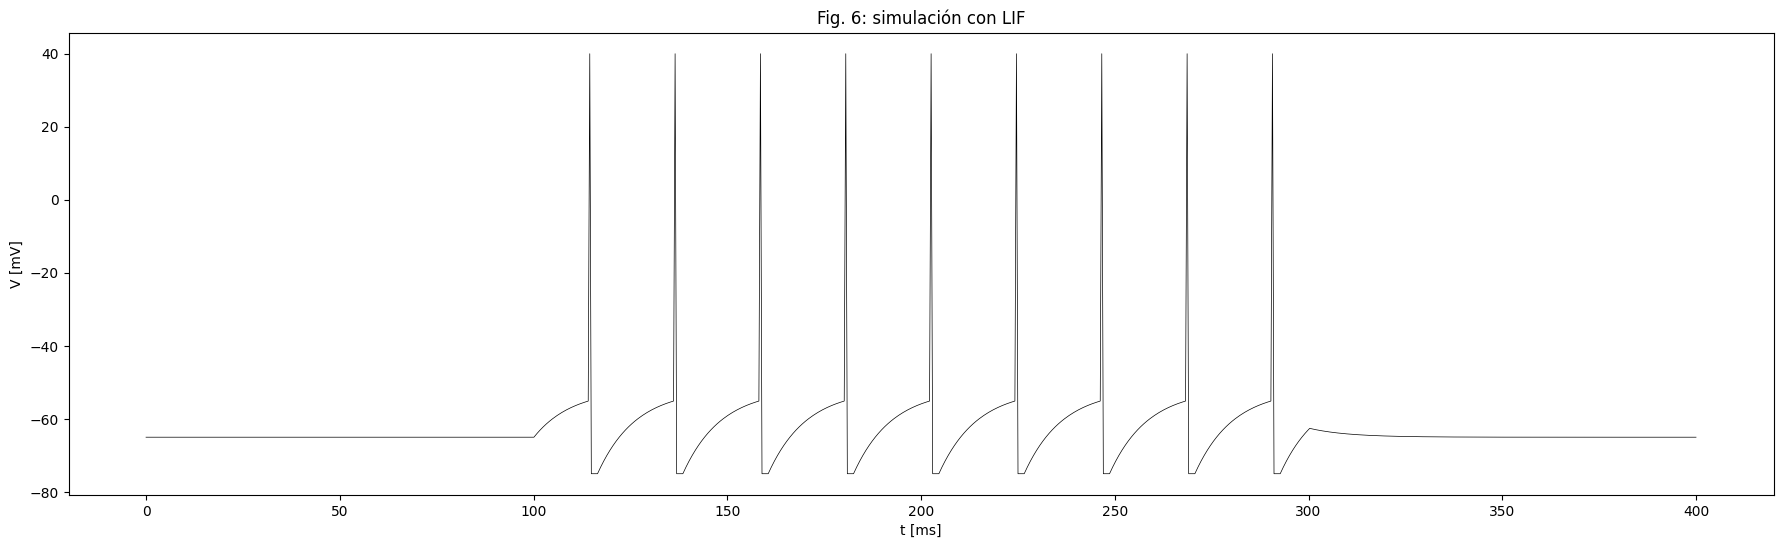

In [10]:
lif_neuron = LIF_model()
t_arr = np.linspace(0, 400*ms, 1000)
i_func = np.vectorize(lambda t : 130*pA*(t>100*ms)*(t<300*ms))
I_arr = i_func(t_arr)

fig_count += 1
title = f"Fig. {fig_count}: simulación con LIF"

_, _ = lif_neuron.simulate_trajectory(t_arr, I_arr, plot=True, title=title)

## AdEx

La familia de los modelos Integrate and Fire adaptativos plantean una ampliación del modelo Leaky Integrate and Fire (LIF) en donde el potencial de membrana (V o u, según el autor) depende de:

La corriente de entrada integrada de aferencias, I(t)
Una no linealidad en el sistema, f(u)
La sumatoria de las corrientes adaptativas, wk(t)

Expresado como sistema de ecuaciones diferenciales, obtenemos

$$
\begin{aligned}
\tau_m \frac{\mathrm{d} u}{\mathrm{~d} t} & =f(u)-R \sum_k w_k+R I(t) \\
\tau_k \frac{\mathrm{d} w_k}{\mathrm{~d} t} & =a_k\left(u-u_{\text {rest }}\right)-w_k+b_k \tau_k \sum_{t^{(f)}} \delta\left(t-t^{(f)}\right)
\end{aligned}
$$

Donde R es la resistencia eléctrica del sistema, urest es el potencial de reposo, los τi son constantes de tiempo, y los bk indican el salto discreto que ocurre en las corrientes wk en los instantes de disparo, t(f) .

La evidencia experimental demostró que una buena elección para la no linealidad del sistema es una función exponencial sumada a la diferencia entre el potencial instantáneo y un potencial de reposo. Esto da origen al modelo Adaptive Exponential Integrate and Fire (AdEx), el cual se rige por las siguientes ecuaciones (asumiendo una única corriente adaptativa w):

$$
\begin{aligned}
& \tau_m \frac{\mathrm{d} u}{\mathrm{~d} t}=-\left(u-u_{\text {rest }}\right)+\Delta_T \exp \left(\frac{u-\vartheta_{r h}}{\Delta_T}\right)-R w+R I(t) \\
& \tau_w \frac{\mathrm{d} w}{\mathrm{~d} t}=a\left(u-u_{\text {rest }}\right)-w+b \tau_w \sum_{t^{(f)}} \delta\left(t-t^{(f)}\right) . \\
&
\end{aligned}
$$

al igual que en el clásico LIF, el potencial se resetea instantáneamente a urest luego de disparar.

### Como hicimos anteriormente mostramos fragmentos de codigo de Adex:

definimos la derivada:

In [54]:
def derivative(self, I_val: float, u: float, w: float) -> np.ndarray:
        """
        Computes instantaneous derivative
        Args:
            I_val (float): instantaneous current
            u (float): instantaneous voltage
            w (float): instantenous adaptative current

        Returns:
            np.ndarray: np.array([du/dy, dv/dt])
        """
        s = self # alias for neater code

        du = -(u - s.V_rest) + s.delta_T*np.exp((u - s.V_rh)/s.delta_T) - s.R*w + s.R*I_val
        dw = s.a*(u - s.V_rest) - w

        return np.array([du/s.tau_m, dw/s.tau_w])

El codigo de la simulacion del modelo:

In [55]:
def simulate_trajectory_(self, t: np.ndarray,
                            I_input: np.ndarray,
                            plot: bool=False,
                            t_units: float=ms,
                            v_units: float=mV) -> Tuple[np.ndarray, np.ndarray]:
        """
        Resuelve numericamente un problema de valor inicial para el modelo LIF

        t: muestras temporales equiespaciadas
        I_arr: muestras de la corriente en los instantes de t
        plot: indica si graficar o no la trayectoria junto al estímulo
        I_units: defaultea a [pA]
        t_units: defaultea a [ms]
        v_units: defaultea a [mV]

        returns: X, tal que X[0, :] = V, y X[1, :] = w
                spike_times: lista con los indices donde ocurre un disparo

        """
        ...

### Testeamos

In [56]:
# Celda auxiliar: definimos parámetros iniciales para generar distintos patrones con AdEx
pars_adex_tonic = {'V_thres' : 0,
                    'tau_m' : 20*mS,
                    'a' : 0*nS,
                    'tau_w' : 30*ms,
                    'b' : 6*pA,
                    'V_reset' : -55*mV}


pars_adex_adapting = {'V_thres' : 0,
                        'tau_m' : 20*mS,
                        'a' : 0*nS,
                        'tau_w' : 100*ms,
                        'b' : 5*pA,
                        'V_reset' : -55*mV}


pars_adex_init_burst = {'V_thres' : 0,
                        'tau_m' : 5*mS,
                        'a' : 0.5*nS,
                        'tau_w' : 100*ms,
                        'b' : 7*pA,
                        'V_reset' : -51*mV}


pars_adex_bursting = {'V_thres' : 0,
                        'tau_m' : 5*mS,
                        'a' : -0.5*nS,
                        'tau_w' : 100*ms,
                        'b' : 7*pA,
                        'V_reset' : -46*mV}


pars_adex_irregular = {'V_thres' : 0,
                        'tau_m' : 9.9*mS,
                        'a' : -0.5*nS,
                        'tau_w' : 100*ms,
                        'b' : 7*pA,
                        'V_reset' : -46*mV}


pars_adex_transient = {'V_thres' : 0,
                        'tau_m' : 10*mS,
                        'a' : 1*nS,
                        'tau_w' : 100*ms,
                        'b' : 10*pA,
                        'V_reset' : -60*mV}

patterns = [pars_adex_tonic, pars_adex_adapting, pars_adex_init_burst, pars_adex_bursting, pars_adex_irregular, pars_adex_transient]
names = ['Tonic','Adapting','Init. burst','Bursting','Irregular','Transient']

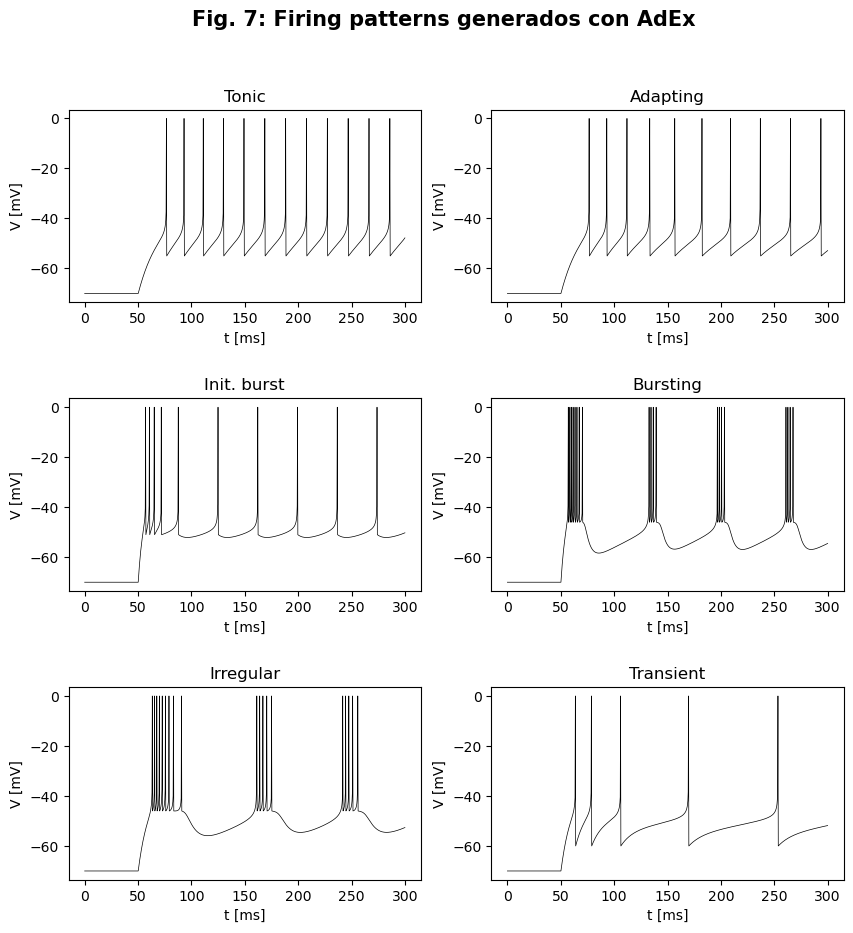

In [57]:
t_adex = np.linspace(0, 300*ms, 1000)
i_0_adex = 65*pA
i_adex_func = np.vectorize(lambda t: i_0_adex*(t>50*ms))
I_arr_adex = i_adex_func(t_adex)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for i, pattern in enumerate(patterns):
  adex_neuron = Adex_model(**pattern)
  X, _ = adex_neuron.simulate_trajectory(t_adex, I_arr_adex, plot=False)
  v_pat = X[0, :]
  
  axs[i//2, i%2].plot(t_adex/ms, v_pat/mV, 'k-', linewidth=0.5)
  axs[i//2, i%2].set_xlabel('t [ms]')
  axs[i//2, i%2].set_ylabel('V [mV]')
  axs[i//2, i%2].set_title(names[i])

fig_count += 1
fig.suptitle(f'Fig. {fig_count}: Firing patterns generados con AdEx', fontweight='semibold', fontsize='15')
plt.subplots_adjust(hspace=0.5)
plt.show()

Como se aprecia en la figura anterior, este modelo nos permite generar distintos patrones de disparo mediante el ajuste de sus parámetros. En el caso sin adaptación, los disparos de las neuronas siguen una frecuencia constante, mientras que en un modelo adaptativo a medida que la neurona recibe un input la frecuencia de disparo va aumentando (esto se puede observar con la distancia entre disparos en low adapting). El mismo comportamiento se puede observar en Burst donde al principio la frecuencia de disparo es muy alta y luego termina siendo hasta más baja que sin la adaptación. 

A continuación, se deja una celda interactiva para analizar el efecto de los parametros a y b sobre AdEx

In [12]:
def interactive_AdEx(a=0.5, b=7):
    """
    Funcion para raelizar simulaciones interactivas con AdEx variando a y b
    """
    # Definimos un pulso de tiempo y una corriente aplicada
    new_adex = Adex_model(a=a*nS, b=b*pA)
    t_arr = np.linspace(0, 300*ms, 1000)
    i_0 = 65*pA
    i_func = np.vectorize(lambda t_i: i_0*(t_i>10*ms)*(t_i<250*ms))
    I_arr = i_func(t_arr)

    # Simulamos
    X_int, spike_times_int = new_adex.simulate_trajectory(t_arr, I_arr, plot=False)
    v_adex = X_int[0, :]
    w_adex = X_int[1, :]

    # Graficamos
    cmap = 'plasma'
    i = np.arange(len(v_adex))
    norm = plt.Normalize(i.min(), i.max())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])
    sc = axs[0].scatter(i, v_adex[i], c=i, s=1, cmap=cmap, norm=norm)
    axs[0].plot(i, v_adex[i], 'red',linewidth = 0.8, alpha =.5)
    axs[0].set_title('Potencial vs. tiempo')
    axs[0].set_xlabel('t [ms]')
    axs[0].set_ylabel('u [mV]')

    sc2 = axs[1].scatter(v_adex, w_adex, c=i, s=1, cmap=cmap, norm=norm)
    cbar = plt.colorbar(sc)
    cbar.set_label('Evolucion temporal')
    axs[1].set_title('Potencial vs. corriente adaptativa')
    axs[1].set_xlabel('u [mV]')
    axs[1].set_ylabel('w [nA]')
    fig.suptitle(f"Fig. {fig_count+1}: Adex interactivo")

    plt.grid(True)
    plt.show()

In [13]:
_ = widgets.interact(interactive_AdEx, a=(0, 5, 0.1), b=(0, 15, 0.2))

interactive(children=(FloatSlider(value=0.5, description='a', max=5.0), FloatSlider(value=7.0, description='b'…

# Resultados

Entrenamos nuestro modelo AdEx con la corriente de entrenamiento, algunas variables estan predifinidas en vista a lo observado en los ploteos de la tension y en numerosas repeticiones del algoritmo para mejorar los tiempos de computo de la funcion. Para no volver a correr el algoritmo de ajuste, a continuación se leerán los parámetros obtenidos desde un .json. Sin embargo, se deja a modo ilustrativo (en un bloque inalcanzable) el código con el que se entrenó al modelo

### Ajuste del modelo Adex

In [14]:
train_adex = False

In [15]:
if train_adex:
    adex = Adex_model(V_reset = -50*mV,
                      V_thres = -35*mV,
                      V_postreset = 40*mV,
                      b = 450*pA,
                      V_rest = -65*mV,
                      delta_T = 1.0*mV)

    adex.fit_spikes(t_train,
                    spike_times_train,
                    I_train,
                    n_per_bin=len(t_train)//10,
                    tweak_keys=['a', 'b', 'delta_T', 'tau_m', 'tau_w', 'R'],
                    tweak_units=[nS, pA, mV, ms, ms, Mohm],
                    N_iter=100,
                    max_rep=15,
                    pop_size=50,
                    mut_rate=0.1,
                    mut_scale=10)
else:
    with open('saved_params/pars_fit_AdEx.json') as file:
        pars_rec = json.load(file)
        adex = Adex_model(**pars_rec)

Procedemos a Simular con la corriente de entrenamiento

* se puede observar como se respeta el comportamiento de la tension comparaado a la tension medida

* en cuanto a los trenes de disparos se respetan tanto los tiempos en los que ocurren como la cantidad de los mismos

* Sin embargo el modelo falla al representar la magnitud de la tension, si bien la tension de reposo esta definida ocurren minimos de -500mV algo que resulta incompatible con la tension medida


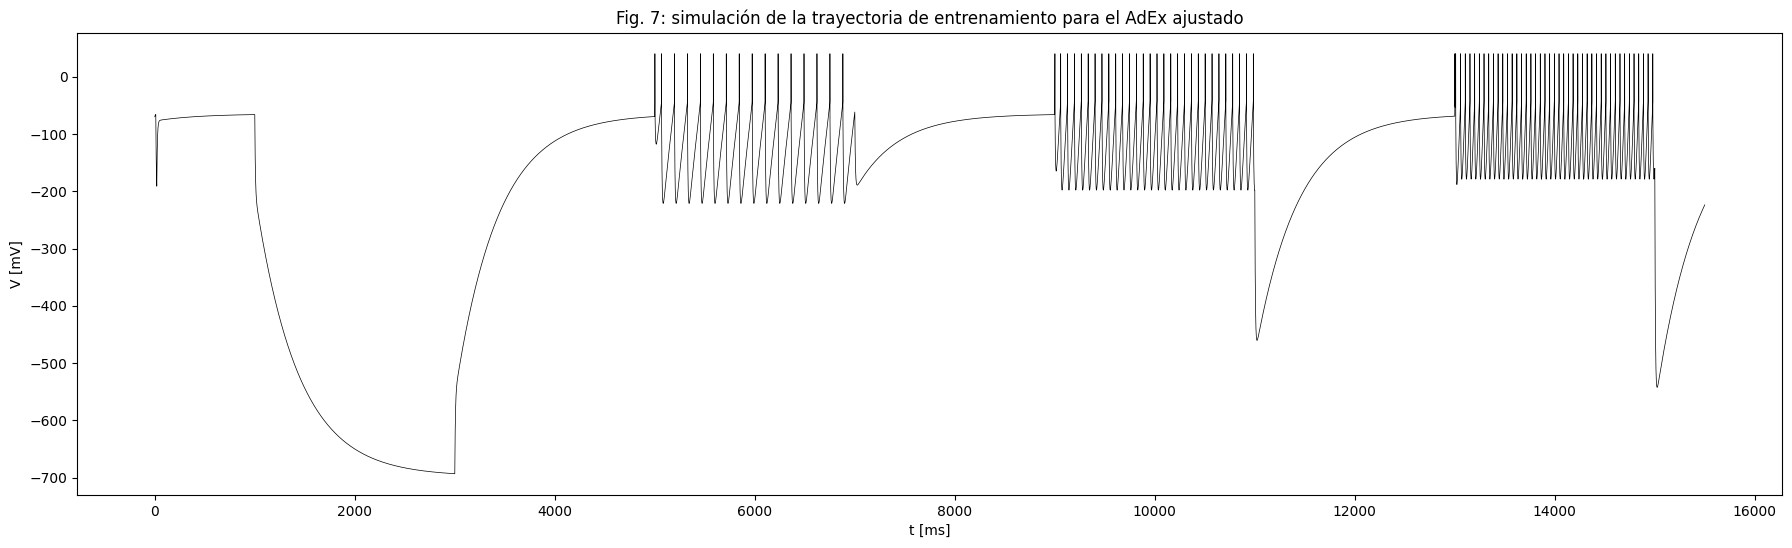

In [16]:
fig_count += 1
title = f"Fig. {fig_count}: simulación de la trayectoria de entrenamiento para el AdEx ajustado"
X, sim_spikes = adex.simulate_trajectory(t_train, I_train, plot=True, title=title)

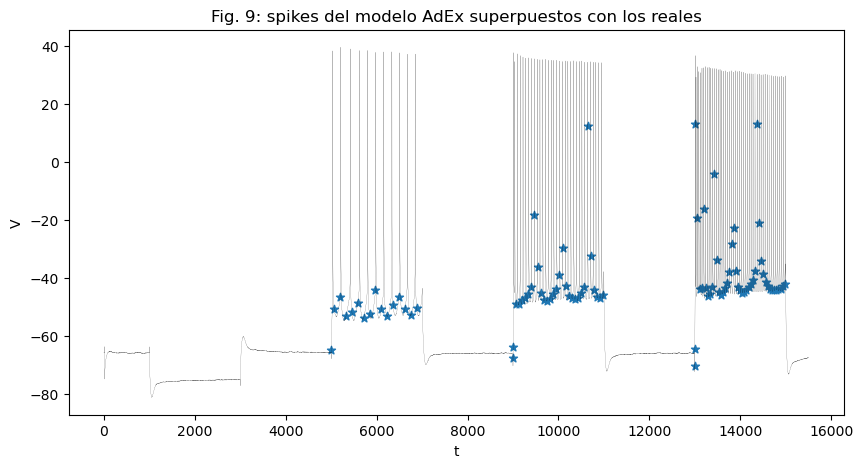

In [63]:
fig_count += 1
plt.figure(figsize=(10, 5))
plt.plot(t_train/ms,v_train, "k-", linewidth=0.1)
plt.scatter(np.array(sim_spikes)/(fs*ms),v_train[sim_spikes],marker="*")
plt.xlabel('t')
plt.ylabel('V')
plt.title(f"Fig. {fig_count}: spikes del modelo AdEx superpuestos con los reales")
plt.show()


A continuación, se simula la respuesta de AdEx frente a la corriente de testeo para compararla con las mediciones

In [64]:
X_adex_test, spikes_adex_test = adex.simulate_trajectory(t_test, I_test, plot=False)
v_adex_test = X_adex_test[0, :]

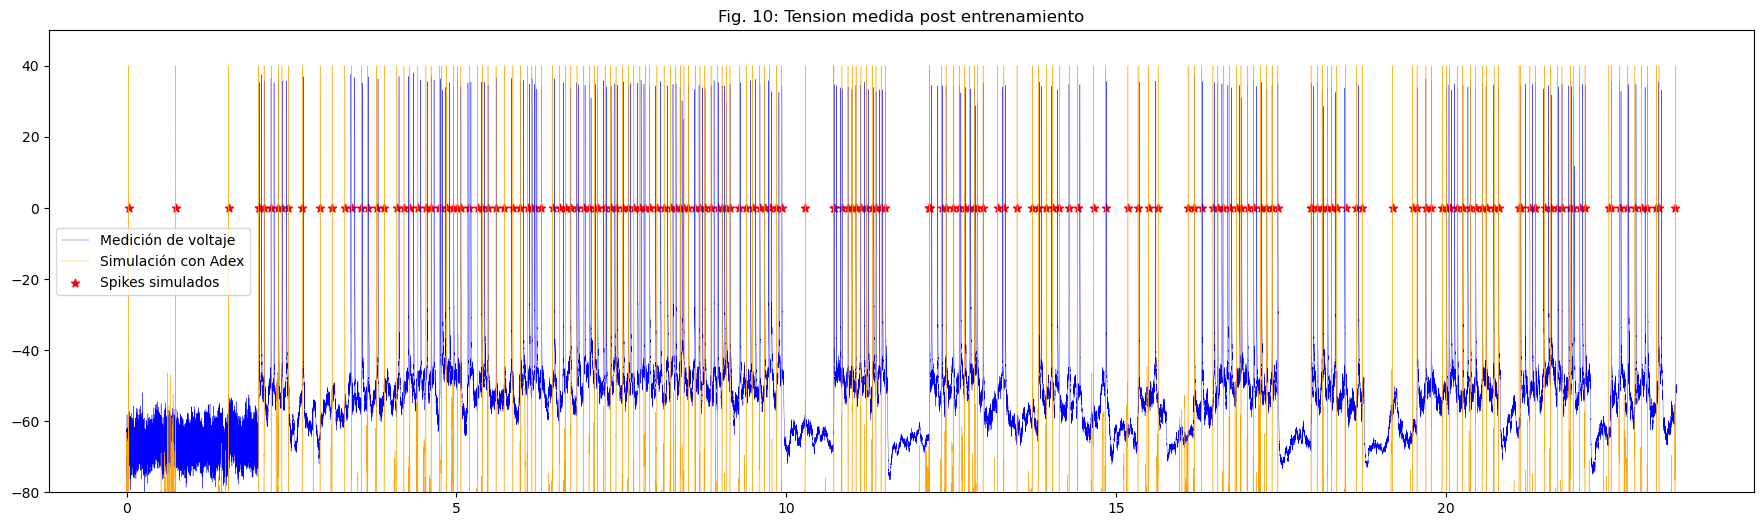

In [65]:
fig_count += 1
plt.figure(figsize=(22,6))
plt.plot(t_test, v_test, linewidth = .25, label='Medición de voltaje', color='blue')
plt.plot(t_test, v_adex_test/mV, linewidth = .3, label='Simulación con Adex', color='orange')
plt.scatter(np.array(spikes_adex_test)/fs, v_adex_test[spikes_adex_test], marker="*", color='red', label='Spikes simulados')
plt.title(f"Fig. {fig_count}: Tension medida post entrenamiento")
plt.ylim(-80, 50)
plt.legend()
plt.show()

Comparamos las tasas de disparos entre Adex y los valores medidos, podemos observar que:

* El mayor error entre tasas de disparos se encuentra en los bins iniciales y finales

* Adex logra calcular de manera aceptable la tasa de disparo para valores intermedios



In [75]:
spike_times_medidos_test, test_peaks_h = find_peaks(v_test, height=0)
rates_adex = firing_rate(t_train, spikes_adex_test, n_per_bin=len(t_train)//10)
rates_obj = firing_rate(t_train, spike_times_medidos_test, n_per_bin=len(t_train)//10)
mat_rate_adex = np.vstack((rates_adex, rates_obj))
pd.DataFrame(mat_rate_adex, columns=[f"bin {i+1}" for i in range(mat_rate_adex.shape[1])], index=['rates sim', 'rates data'])

,bin 1,bin 2,bin 3,bin 4,bin 5,bin 6,bin 7,bin 8,bin 9,bin 10
rates sim,3,9,13,17,16,19,12,13,14,9
rates data,0,9,11,20,21,23,13,16,14,6


### Ajuste del modelo LIF

In [67]:
train_lif = False

In [68]:
if train_lif:
    lif = LIF_model(V_th=-40*mV, V_reset=-55*mV)
    lif.fit_spikes(t_train,
                  spike_times_train,
                  I_train,
                  n_per_bin=len(t_train)//8,
                  tweak_keys=['tau_m', 'g_L', 'V_th'],
                  tweak_units=[ms, nS, mV],
                  N_iter=100,
                  max_rep=7,
                  pop_size=50,
                  mut_rate=0.1,
                  mut_scale = 5)
else:
    with open('saved_params/pars_fit_LIF.json') as file:
        lif_kwargs = json.load(file)
    lif = LIF_model(**lif_kwargs)

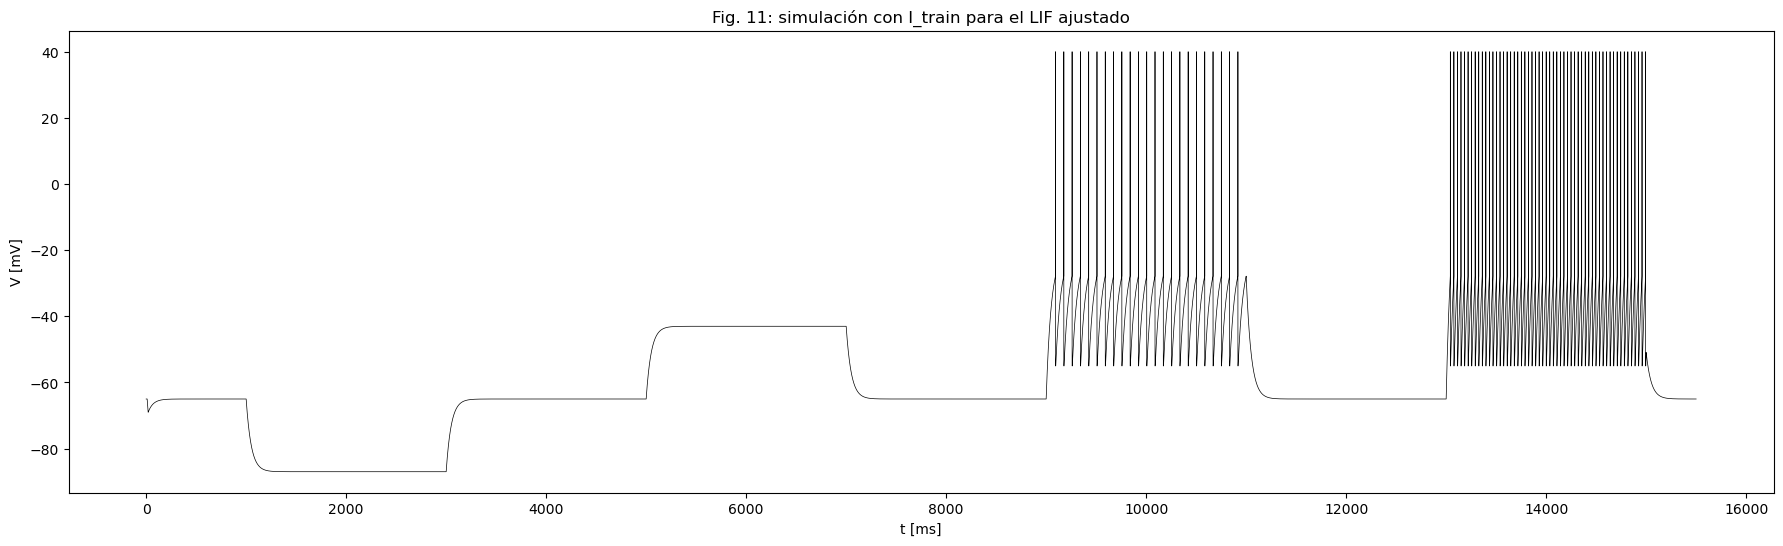

In [69]:
fig_count += 1
title = f"Fig. {fig_count}: simulación con I_train para el LIF ajustado"
fit_v_lif, spikes_LIF_train = lif.simulate_trajectory(t_train, I_train, plot=True, title=title);

Podemos observar claramente como LIF falla para el primer tren de disparos y a medida que pasa el tiempo se ajusta mejor a la realidad, por otro lado comparamos las tasas de disparos y hallamos lo mismo, para valores iniciales falla pero para los ultimos valores ajusta bien.

Sin embargo, notese que adapta mejor las magnitudes que adex, respetando tanto la altura de los picos como los valores post reset. Siendo este un enorme punto a favor de LIF frente a AdEx, se pone en juego lo que uno busca precision en la magnitud o precision en los eventos.

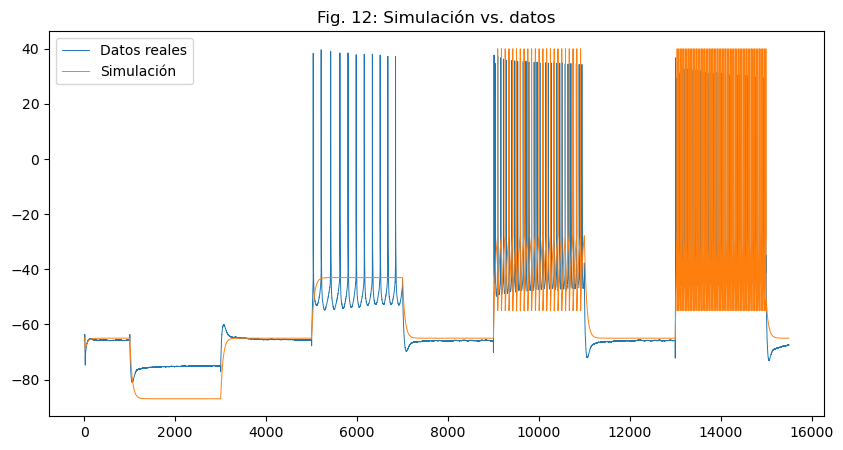

In [70]:
fig_count += 1
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_train/ms, v_train, linewidth=0.7, label='Datos reales')
ax.plot(t_train/ms, fit_v_lif/mV, linewidth=0.7, label='Simulación')
ax.set_title(f"Fig. {fig_count}: Simulación vs. datos")
plt.legend()
plt.show()

In [76]:
rates_lif = firing_rate(t_train, spikes_LIF_train, n_per_bin=len(t_train)//10)
rates_obj = firing_rate(t_train, spike_times_train, n_per_bin=len(t_train)//10)
mat_fr = np.vstack((rates_lif, rates_obj))
pd.DataFrame(mat_fr, columns=[f"bin {i+1}" for i in range(mat_fr.shape[1])], index=['rates sim', 'rates data'])

,bin 1,bin 2,bin 3,bin 4,bin 5,bin 6,bin 7,bin 8,bin 9,bin 10
rates sim,0,0,0,0,0,3,19,1,26,30
rates data,0,0,0,7,4,6,25,2,25,24


Al momento de simular el tiempo restante observamos que ya no se obtiene esa señal ruidosa que representaba el valor medido, sino que se genera una señal más "limpia" con los tiempos de disparos muy marcados. Gran parte de la señal se encuentra por debajo de los -60mV, y debido a su magnitud no deberian de provocar el disparo de una neurona. Sin embargo, el ruido hace que se supere el valor threshold para una pequeña cantidad de valores, provocando disparos. Por lo tanto, LIF podria estar representando de una manera más visualmente agradable los disparos de las neuronas durante la corriente de test.

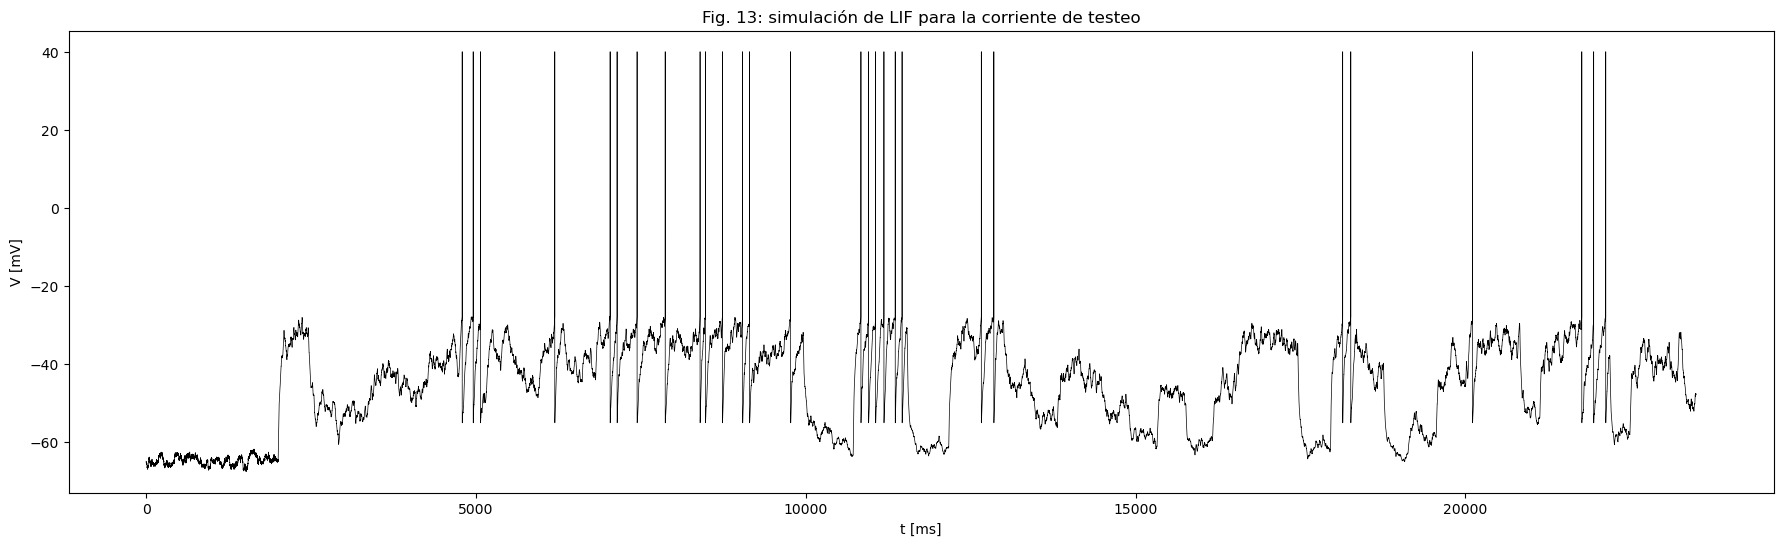

In [72]:
fig_count += 1
title = f"Fig. {fig_count}: simulación de LIF para la corriente de testeo"
vsim_lif_test, spikes_lif_test = lif.simulate_trajectory(t_test, I_test, plot=True, title=title);

Comparando las tasas de disparo podemos observar como LIF logra aproximarse bastante a las tasas de disparo medidas en el experimento por lo que LIF podria hasta ser un modelo mas optimo para AdEx

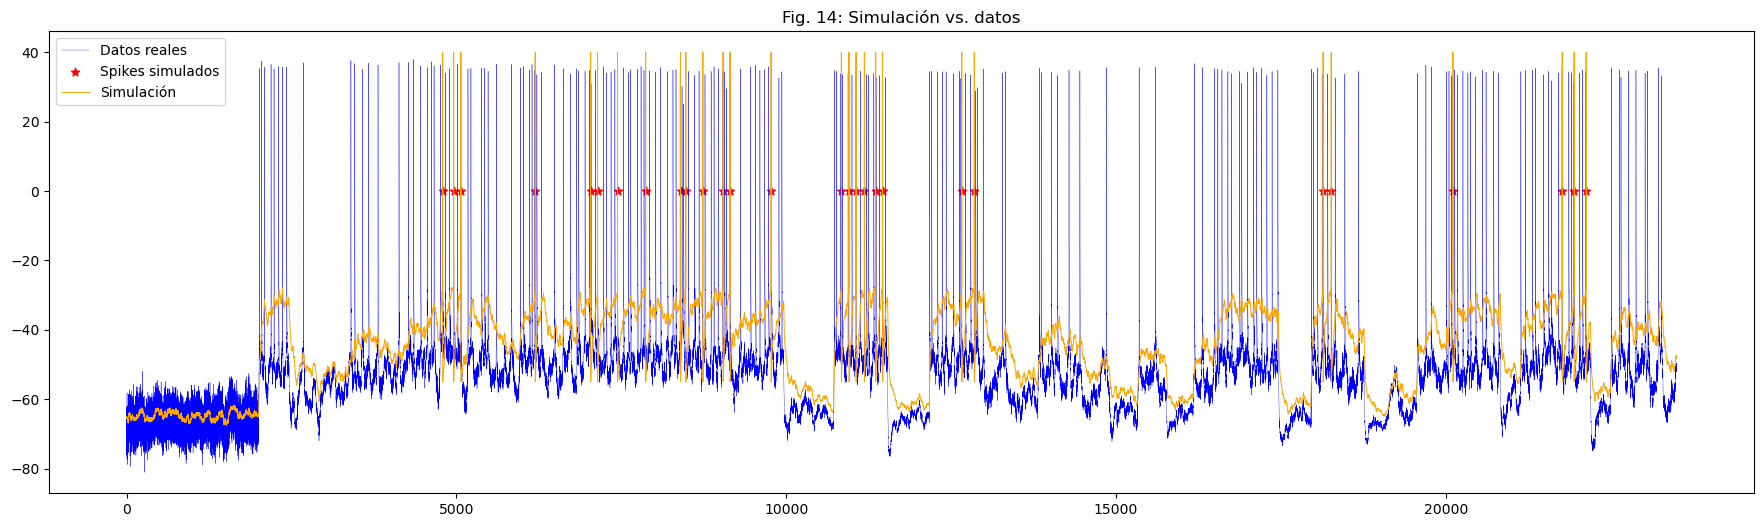

In [73]:
fig_count += 1
fig, ax = plt.subplots(figsize=(22, 6))
ax.plot(t_test/ms, v_test, linewidth=0.25, color='blue', label='Datos reales')
ax.scatter(spikes_lif_test/(fs*ms), vsim_lif_test[spikes_lif_test], marker="*", color='red', label='Spikes simulados')
ax.plot(t_test/ms, vsim_lif_test/mV, linewidth=0.7, color='orange', label='Simulación')
ax.set_title(f"Fig. {fig_count}: Simulación vs. datos")
plt.legend()
plt.show()

Finalmente, comparamos los firing rates binneados:

In [77]:
spike_times_medidos_test, test_peaks_h = find_peaks(v_test, height=0)
rates_lif = firing_rate(t_test, spikes_lif_test, n_per_bin=len(t_test)//10)
rates_obj = firing_rate(t_test, spike_times_medidos_test, n_per_bin=len(t_test)//10)
mat_fr_lif_test = np.vstack((rates_adex, rates_obj))
pd.DataFrame(mat_fr_lif_test, columns=[f"bin {i}" for i in range(mat_fr_lif_test.shape[1])], index=['rates sim', 'rates data'])

,bin 0,bin 1,bin 2,bin 3,bin 4,bin 5,bin 6,bin 7,bin 8,bin 9
rates sim,3,9,13,17,16,19,12,13,14,9
rates data,6,15,29,35,24,19,8,24,17,24


## Discusión

Los modelos implementados en esta biblioteca presentan un gran flexibilidad, su uso es intuitivo, y el manejo interno de unidades es de fácil comprensión. La generalidad de la clase NeuronModel permitiría, a futuro, implementar nuevos modelos basados en esta misma plantilla. 

A la hora de ajustar a los datos reales, los resultados obtenidos con el modelo LIF fueron más precisos en la señal de testeo. Creemos que estos errores en el fiteo pueden mejorar si:

* Utilizamos un mejor algoritmo de fiteo: El algoritmo genético requiere mucha materia de computo para conseguir estos resultados, solo llegar a estos parametros requirio de media hora de computo

* Definimos mejor los valores semilla: A lo largo de numerosas iteraciones notamos que el fiteo y su convergencia mejoran si eligimos valores semilla mas cercanos a los de la realidad (cosa que hace muchisimo sentido), aun asi la idea de estos metodos es hallar valores que desconocemos por lo que no tendria sentido asignarles valores si no que seria como un fiteo a la fuerza y a ojimetro

* En lugar de valores semillas podriamos tomar valores aleatorios en un rango determinado para poder sumar aleatoridad y evitar caer en un punto silla por accidente

* Aumentar la variabilidad entre generaciones: las mutaciones estan definidas para ser normales de desvio 1, si aumentamos el desvio entre generaciones podriamos mejorar la variabilidad genetica y hayar mejores soluciones

* Tal vez AdEx no es el mejor modelo para adaptar esta corriente para poder representar la magnituda de la respuesta y LIF no es el mejor para representar los tiempos de disparo

Por otra parte, se deben ajustar múltiples parámetros a la vez para Adex incluso habiendo fijado todos los que se podían inferir directamente de las mediciones. Con LIF, se trabajó con menos grados de libertad, lo que permitió una mejor convergencia. 

Como potencial mejora para este proyecto, podría plantearse un nuevo método para el ajusto de parámetros, como alternativa al algoritmo genético propuesto. Por otra parte, también podría hacerse uso del algoritmo ya existente, pero considerando otra función de costo distinta al error cuadrático medio de las tasas de disparo binneadas.

Aqui nace la discusion de que se busca cuando implementamos nuestros modelos. Si buscamos precision en tanto a la magnitud LIF representa mejor a la señal medida pero no lo hace con los disparos, si buscamos precision en tanto tiempos de disparos AdEx logro modelar de manera precisa los mismos aunque nazcan valores muy lejanos en tanto magnitud como depresiones de -700 mv cuando el valor mas bajo medido es de aproximadamente -100mV. Consideramos que si uno busca representar la actividad neuronal le dara mas importancia a los tiempos de disparos de la neurona y a su comportamiento adaptativo y creemos  uqe puede llegar a tener mas utilidad que representar unicamente bien la magnitud porque al fin y al cabo lo que interesa en la mayoria de experimentos es representar de manera adecuada los trenes de disparo mas que la magnitud de la señal en general. Basicamente, el investigador utilizara el modelo que mejor se ajuste a lo que busca y ahi reside la utilidad de generar no uno sino 3 modelos distintos (aunque solo testeamos con datos reales 2) de manera tal de dar variabilidad al usuario respecto a sus objetivos. 

En el futuro se podrian desarollar otros modelos de neurona vistos en clase que podrian representar de mejor manera el comportamiento de la misma que lo que lo hicieron LIF y AdEx.

## Conclusión

En conclusión, la biblioteca neuron_models permite simular y ajustar modelos mecanicistas de potencial de membrana de neurona única. Esta herramienta podría ser de utilidad para futuros investigadores o docentes de neurociencia computacional, e incluso se podría ampliar para abarcar nuevos sistemas sin mayor dificultad. Sus implementaciones de LIF y Adex permitieron ajustarse a mediciones reales mediante un algoritmo genético basado en minimizar el ECM en las tasas de disparo por intervalos temporales. Como mejoras al proyecto, para futuras versión, se proponer investigar alternativas para este algoritmo.

## Referencias
[1] «6.1 Adaptive Exponential Integrate-and-Fire | Neuronal Dynamics online book». Accedido: 16 de julio de 2024. [En línea]. Disponible en: https://neuronaldynamics.epfl.ch/online/Ch6.S1.html

[2] «Chapter 2 Ion Channels and the Hodgkin-Huxley Model | Neuronal Dynamics online book». Accedido: 16 de julio de 2024. [En línea]. Disponible en: https://neuronaldynamics.epfl.ch/online/Ch2.html

[3] W. Gerstner et al., «Quantitative Single-Neuron Modeling Competition for year 2009, developed by 			researchers at EPFL. Data from Wistar rat cortical neurons and rhesus monkey 			lateral geniculate nucleus and retinal ganglion cells.» CRCNS.org, p. 51 MB, 2009. doi: 10.6080/K0PN93H3.
